In [1]:
import sys
sys.path.append("../../../")

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from model.losses import *
from model.bpho.multi import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

In [3]:
torch.cuda.set_device(3)

# Model loading

### load data

In [4]:
bs = 8  # batch size
size = 200  # image size
tile_sz=512 
lr_type = 't'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [5]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [6]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


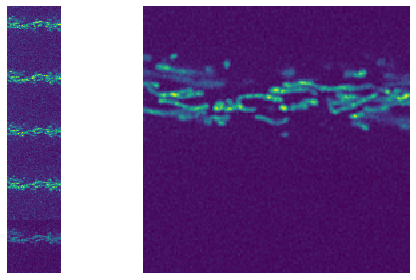

In [7]:
data.show_batch(rows=1)

### initiate learner

In [8]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

In [9]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                         metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)

In [10]:
learn.model_dir

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')

In [11]:
model_name = 'fluo_inpainting_new_100epoch'
learn = learn.load(file=model_name)

In [12]:
learn

Learner(data=MultiImageDataBunch;

Train: LabelList (5000 items)
x: MultiImageImageList
MultiImage: ['Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)'],MultiImage: ['Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)'],MultiImage: ['Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)'],MultiImage: ['Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)'],MultiImage: ['Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)', 'Image (1, 50, 50)']
y: ImageList
Image (1, 200, 200),Image (1, 200, 200),Image (1, 200, 200),Image (1, 200, 200),Image (1, 200, 200)
Path: /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5;

Valid: LabelList (200 items)
x: MultiImageImageList
MultiImage: ['Image (1, 50, 50)', 'Image (1, 50, 50

# load testing data

In [13]:
import shutil
from skimage.filters import gaussian
from skimage.io import imsave
import PIL
import imageio
from scipy.ndimage.interpolation import zoom as npzoom
import czifile
import PIL
import numpy as np
from fastprogress import progress_bar
from pathlib import Path
import torch
import math
from time import sleep
import shutil
from skimage.util import random_noise
from skimage import filters
from torchvision.models import vgg16_bn

def img_to_uint8(img, img_info=None):
    img = img.copy()
    if img_info and img_info['dtype'] != np.uint8:
        img -= img.min()
        img /= img.max()
        img *= np.iinfo(np.uint8).max
    return img.astype(np.uint8)

def unet_multi_image_from_tiles(learn, in_img, tile_sz=128, scale=4, wsize=3):
    cur_size = in_img.shape[1:3]
    c = in_img.shape[0]
    new_size = (cur_size[0] * scale, cur_size[1] * scale)
    w, h = cur_size

    in_tile = torch.zeros((c, tile_sz // scale, tile_sz // scale))
    out_img = torch.zeros((1, w * scale, h * scale))
    tile_sz //= scale

    for x_tile in range(math.ceil(w / tile_sz)):
        for y_tile in range(math.ceil(h / tile_sz)):
            x_start = x_tile

            x_start = x_tile * tile_sz
            x_end = min(x_start + tile_sz, w)
            y_start = y_tile * tile_sz
            y_end = min(y_start + tile_sz, h)

            in_tile[:, 0:(x_end - x_start), 0:(y_end - y_start)] = tensor(
                in_img[:, x_start:x_end, y_start:y_end])

            img_list = [
                Image(tensor(npzoom(in_tile[i], scale, order=1))[None])
                for i in range(wsize)
            ]
            #img_list += img_list

            tlist = MultiImage(img_list)
            out_tile, _, _ = learn.predict(tlist)

            out_x_start = x_start * scale
            out_x_end = x_end * scale
            out_y_start = y_start * scale
            out_y_end = y_end * scale

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = (x_end - x_start) * scale
            in_y_end = (y_end - y_start) * scale
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)

            out_img[:, out_x_start:out_x_end, out_y_start:
                    out_y_end] = out_tile.data[:, in_x_start:in_x_end,
                                               in_y_start:in_y_end]
    return out_img


def tif_predict_movie(learn,
                      tif_in,
                      orig_out='orig.tif',
                      pred_out='pred.tif',
                      size=128,
                      wsize=3):
    im = PIL.Image.open(tif_in)
    im.load()
    times = im.n_frames
    #times = min(times,100)
    imgs = []

    if times < (wsize + 2):
        print(f'skip {tif_in} only {times} frames')
        return

    for i in range(times):
        im.seek(i)
        imgs.append(np.array(im).astype(np.float32) / 255.)
    img_data = np.stack(imgs)

    def pull_frame(i):
        im.seek(i)
        im.load()
        return np.array(im)

    preds = []
    origs = []
    img_max = img_data.max()

    x, y = im.size
    #print(f'tif: x:{x} y:{y} t:{times}')
    for t in progress_bar(list(range(0, times - wsize + 1))):
        img = img_data[t:(t + wsize)].copy()
        img /= img_max

        out_img = unet_multi_image_from_tiles(learn,
                                              img,
                                              tile_sz=size,
                                              wsize=wsize)
        pred = (out_img * 255).cpu().numpy().astype(np.uint8)
        preds.append(pred)
        orig = (img[1][None] * 255).astype(np.uint8)
        origs.append(orig)
    if len(preds) > 0:
        all_y = img_to_uint8(np.concatenate(preds))
        imageio.mimwrite(
            pred_out, all_y,
            bigtiff=True)  #, fps=30, macro_block_size=None) # for mp4
        all_y = img_to_uint8(np.concatenate(origs))
        imageio.mimwrite(orig_out, all_y,
                         bigtiff=True)  #, fps=30, macro_block_size=None)

In [14]:
test_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/mitotracker_videos/mitotracker_video_01_LR_8bit.tif')

In [15]:
tif_predict_movie(learn, test_pth, orig_out='original.tif', pred_out=f'{model_name}.tif', size=200, wsize=5)

In [120]:
test_files = sorted(list(test_pth.glob('*.tif')))

In [121]:
test_files[0]

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/test_datasources/NEW_non-moving_mitotracker/lowres_1.tif')

In [122]:
### Convert TIFF stacks to npy files for model inference
from libtiff import TIFF
img_size = 250
test_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/test_datasources/NEW_non-moving_mitotracker')
test_files = sorted(list(test_pth.glob('*.tif')))
for tif_fname in test_files:
    tif = TIFF.open(tif_fname)
    img_stack = np.zeros((10, img_size, img_size), dtype=np.uint8)
    for i, img in enumerate(tif.iter_images()):
        img_stack[i] = img
    for i in range(6):
        five_stack = np.zeros((5, img_size, img_size), dtype=np.uint8)
        five_stack = img_stack[i:i+5]
        npy_fname = str(tif_fname)+f'_{i}.npy'
        np.save(npy_fname, five_stack)

In [87]:
five_stack

dtype('float64')

In [105]:
np.load(test_pth/'realworld_lowres_lowpower_4_LR.tif_5.npy', )

dtype('float64')

In [68]:
five_stack

array([[[0., 1., 1., 0., ..., 1., 0., 0., 0.],
        [2., 0., 1., 1., ..., 0., 0., 0., 0.],
        [4., 0., 0., 1., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 1.],
        ...,
        [1., 1., 0., 0., ..., 1., 0., 0., 0.],
        [0., 0., 0., 1., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[3., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 3., 0., 0., ..., 0., 0., 1., 0.],
        [1., 1., 0., 0., ..., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 1., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 2.]],

       [[2., 0., 0., 3., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 3., 0., 1.],
        [0., 0., 0., 0., ..., 0., 0., 0., 3.],
        [0., 0., 0., 0., ..., 0., 0., 1., 0.],
        ...,
        [1., 0., 

In [61]:
five_stack.shape

(5, 250, 250)

In [22]:
img_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5/valid/mitotracker')
img = np.load(img_pth/'mitotracker_PSSR-MF_valid_lr_001.npy')

In [23]:
img.shape

(5, 126, 126)

In [14]:
learn.data.add_test(test_set, tfm_y=False)

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [34]:
np.load(test_pth/'realworld_lowres_lowpower_10_LR.tif')

ValueError: Cannot load file containing pickled data when allow_pickle=False

## test

In [16]:
sys.path.append("../../../model")

In [17]:
critic_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models')
critic = load_learner(path=critic_pth/'baselines', file='mitotracker_PSSR-SF_512.pkl')

# Inference

In [75]:
critic.data.add_test(test_set, tfm_y=False)

In [76]:
critic.data.test_ds[0]

(Image (3, 128, 128), EmptyLabel )

In [67]:
file=test_pth/'realworld_lowres_lowpower_10_LR.tif'

In [68]:
file.exists()

True

In [69]:
img2=PIL.Image.open(file)

In [70]:
img2.size

(250, 250)

In [77]:
hr_pth=Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/HR/real-world_mitotracker')

In [78]:
hr_file=hr_pth/'realworld_highres_01_HR.tif'

In [79]:
hr_img=PIL.Image.open(hr_file)

In [80]:
hr_img.size

(1000, 1000)

In [58]:
img.data.shape

torch.Size([3, 128, 128])

In [34]:
for img, img_name in zip(critic.data.test_ds, critic.data.test_ds.items):
    pred = critic.predict(img[0])
    break

RuntimeError: Given groups=1, weight of size 32 1 3 3, expected input[1, 3, 512, 512] to have 1 channels, but got 3 channels instead

In [10]:
files = sorted(list(data_pth.glob('*.tif')))

In [12]:
files[0]

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/hr_t_512_t_5/train/mitotracker/mitotracker_PSSR-MF_train_hr_0001.tif')

In [16]:
img=PIL.Image.open(files[0])

In [18]:
img.size

(512, 512)

In [7]:
# Store dataset in a databunch object 
data = get_data(data_pth, lr_dir, hr_dir, bs, 
                in_sz=size, out_sz=size, max_zoom=1.)

In [8]:
from model.metrics import psnr, ssim
superres_metrics = [F.mse_loss, psnr, ssim]

In [85]:
def model_inference(learner=learn, nb=nb_name, img_tag=f'{nb_name}.{expt_num}'):
    for img, img_name in zip(learner.data.test_ds, learner.data.test_ds.items):
        pred = learner.predict(img[0])
        pred_name = str(img_name).replace('FRC_8bit', nb+'/FRC').replace('000000', '_'+img_tag+'_')
        pred[0].save(pred_name)
        print(f"Performed inference on {img_name.stem}, file saved as {pred_name}")
    print("Model Inference Complete")

In [87]:
for pth in ['EM/testing/FRC_8bit/2_8bit', 'EM/testing/FRC_8bit/3_8bit']:
    test_pth = data_pth/pth
    print(test_pth)
    print(test_pth.exists())
    test_set = ImageList.from_folder(test_pth)
    learn.data.add_test(test_set, tfm_y=False)
    model_inference(learn)

/home/alaa/Dropbox/BPHO Staff/USF/EM/testing/FRC_8bit/2_8bit
True
Performed inference on 2_8bit00000007, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_07.tif
Performed inference on 2_8bit00000000, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_00.tif
Performed inference on 2_8bit00000006, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_06.tif
Performed inference on 2_8bit00000002, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_02.tif
Performed inference on 2_8bit00000015, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss_pssr_baseline/FRC/2_8bit/2_8bit_featureloss-resnet34-mse-baseline.3b_15.tif
Performed infe

## DEV

In [25]:
ex_img = learn.data.test_ds[0]
ex_img_name = learn.data.test_ds.items[0]

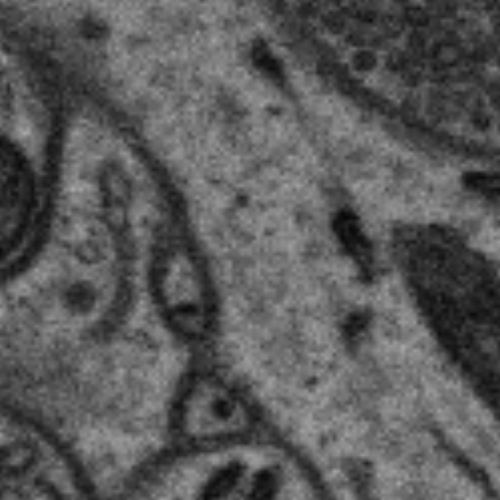

In [30]:
ex_img[0]

In [35]:
img = utils.load_img("test_inference.tif")

In [28]:
pred = learn.predict(ex_img[0])

In [31]:
pred[0].save("test_inference.tif")

In [42]:
ex_img_name.stem

'realword_SEM_test_lr_05'

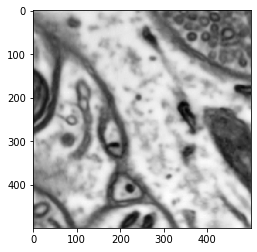

In [39]:
plt.imshow(np.squeeze(img), cmap=plt.cm.gray)